In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

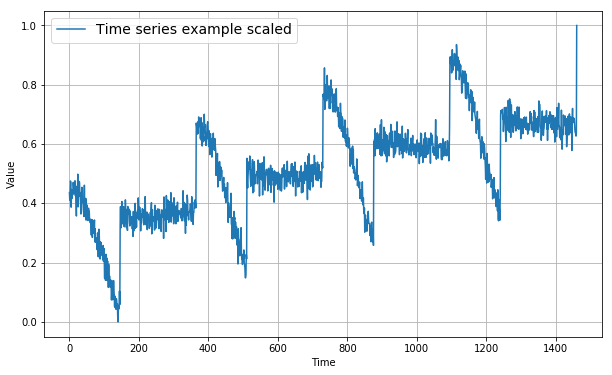

In [2]:
# Define the time series
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * (np.sqrt(time))

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# The time series
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time,0.5) + white_noise(time, noise_level=1, seed=0) + seasonality(time, period=365, amplitude=10, phase=0)
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(series.reshape(-1,1))
series = scaler.transform(series.reshape(-1,1))[0:,0]
#Plot
plt.figure(figsize=(10, 6))
plot_series(time, series, label='Time series example scaled')
plt.show()

In [3]:
def seq2seq_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Reset states on epoch end
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [4]:
# Train and validation split
x_train = time[:1000]
y_train = series[:1000]
x_val = time[1000:]
y_val = series[1000:]
# Train and val sets
window_size = 64
train_set = seq2seq_window_dataset(y_train, window_size, batch_size=128)
val_set = seq2seq_window_dataset(y_val, window_size, batch_size=128)

In [5]:
# Model fitting: waveNET (google-DeepMind)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      tf.keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1)) # Last classification layer

model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "wavenet_checkpoint.h5", save_best_only=True)
reset_states = ResetStatesCallback()

model.fit(train_set, epochs=200, validation_data=val_set,
          callbacks=[early_stopping, reset_states, model_checkpoint])

Epoch 1/200
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
8/8 [==============================] - 5s 631ms/step - loss: 0.1043 - mae: 0.4327 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/200
8/8 [==============================] - 1s 140ms/step - loss: 0.0760 - mae: 0.3487 - val_loss: 0.1014 - val_mae: 0.4225
Epoch 3/200
8/8 [==============================] - 1s 139ms/step - loss: 0.0361 - mae: 0.2128 - val_loss: 0.0510 - val_mae: 0.2639
Epoch 4/200
8/8 [==============================] - 1s 140ms/step - loss: 0.0263 - mae: 0.1851 - val_loss: 0.0372 - val_mae: 0.2233
Epoch 5/200
8/8 [==============================] - 1s 136ms/step - loss: 0.0166 - mae: 0.1442 - val_loss: 0.0338 - val_mae: 0.2103
Epoch 6/200
8/8 [==============================] - 1s 144ms/step - loss: 0.0126 - mae: 0.1230 - val_loss: 0.0186 - val_mae: 0.1460
Epoch 7/200
8/8 [==============================] - 1s 142ms/step - loss: 0.0091 - mae: 0.1051 - val_loss: 0.0156

In [8]:
model = tf.keras.models.load_model("wavenet_checkpoint.h5")

0.0007422261


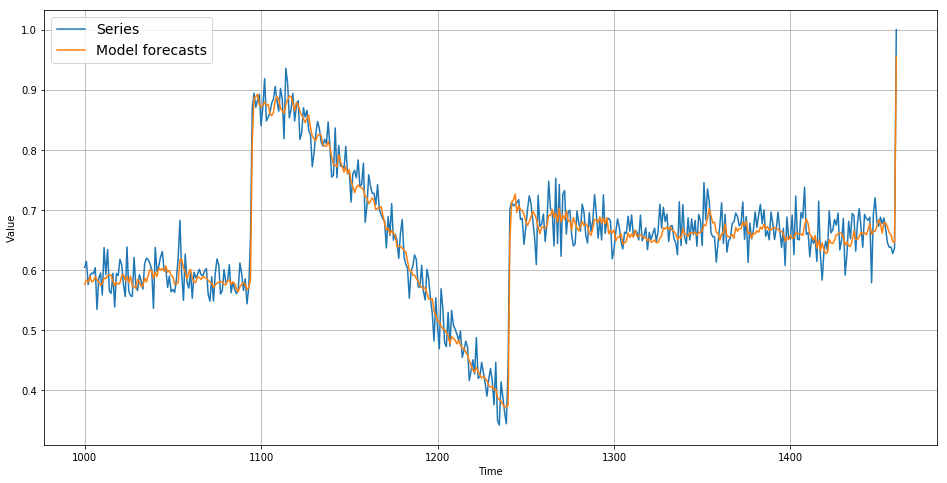

In [12]:
model.reset_states()
rnn_forecasts = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecasts = rnn_forecasts[0, 1000:, 0]
plt.figure(figsize=(16,8))
plot_series(x_val, y_val, label='Series')
plot_series(x_val, rnn_forecasts, label='Model forecasts')
print(tf.keras.metrics.mean_squared_error(y_val, rnn_forecasts).numpy())